# **Text Classification with the BBC News Dataset**

This notebook demonstrates the implementation of a multiclass text classification model using LSTM networks to classify [BBC news articles](https://www.kaggle.com/c/learn-ai-bbc/overview) into 5 categories: 'business', 'entertainment', 'politics', 'sport', 'tech'. Additionally, it includes visualization of word embeddings generated after training.

### **Imports**

In [1]:
import tensorflow as tf
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from IPython.core.display import HTML
from google.colab import drive
import imageio.v2 as imageio
import os

### **Parameters**

In [2]:
epochs = 10
batch_size = 32
vocab_size = 10000 #Including padding and unknown tokens
embedding_dim = 128

### **Load and Preprocess the Dataset**

In [3]:
data_url = "http://mlg.ucd.ie/files/datasets/bbc-fulltext.zip"

# Download dataset
!wget -q $data_url  -O /content/bbc.zip

# Unzip the dataset
!unzip -q /content/bbc.zip

In [4]:
# Function to generate training and testing datasets from the data directory

directory = "/content/bbc"

def load_data(directory=directory, subset="training"):

  dataset = tf.keras.utils.text_dataset_from_directory(
      directory=directory,
      labels="inferred",
      label_mode="int",
      batch_size=batch_size,
      shuffle=True,
      seed=123,
      validation_split=0.2,
      subset=subset
  )
  return dataset

In [5]:
train_dataset = load_data()
test_dataset = load_data(subset="validation")

Found 2225 files belonging to 5 classes.
Using 1780 files for training.
Found 2225 files belonging to 5 classes.
Using 445 files for validation.


In [6]:
for texts, labels in train_dataset.take(1):
  print(texts[:3].numpy(), "\n")
  print(labels[:3].numpy())

[b'Hard act to follow for OutKast\n\nUS rap duo OutKast\'s trio of trophies at the MTV Europe Awards crowns a year of huge success for the band.\n\nThe latest triumph adds to the three Grammys and four American MTV gongs won earlier in this year. Andre 3000 and Big Boi\'s album Speakerboxxx/The Love Below has been critically acclaimed since its release and sold in large quantities around the world. The double album - which saw the pair produce one disc each - topped the charts in the US at the same time as single Hey Ya! It took another track from the exponents of southern hip-hop - The Way You Move - to displace it from the top spot. The Georgia pair\'s year of critical and commercial triumph leaves them with a tough act to follow - what can be next for a musical act that has done it all?\n\nG Money, a presenter on the BBC\'s urban music station 1Xtra, thinks a hiatus is inevitable after such a sustained period of exposure - giving the band time to think about other interests. "They m

In [7]:
# Observing the label names
class_names = train_dataset.class_names
print(class_names)
print(np.unique(labels.numpy()))

['business', 'entertainment', 'politics', 'sport', 'tech']
[0 1 2 3 4]


In [3]:
n_classes = len(class_names)
n_classes

5

**Text Encoder Creation**

Text processing utilizes the ``TextVectorization`` layer, which encodes text into indices by frequency order (following the padding token and the unknown token), considering up to ``vocab_size``. Index tensors are padded with zeros up to the longest sequence in the batch (unless you set a fixed value for ``output_sequence_length``).

In [8]:
# Create a custom standardization function

@tf.keras.saving.register_keras_serializable()
def preprocessing(text):
  # Convert all text to lowercase
  text = tf.strings.lower(text)
  # Removing punctuation, including the pound sterling symbol
  text = tf.strings.regex_replace(text, r'[!"#$£%&()\*\+,-\./:;<=>?@\[\\\]^_`{|}~\']', "")
  # Removing line breaks
  text = tf.strings.regex_replace(text, r"\n+", " ")
  return text

In [9]:
encoder = tf.keras.layers.TextVectorization(max_tokens=vocab_size,
                                            standardize=preprocessing)
encoder.adapt(train_dataset.map(lambda text, label: text))
vocab = np.array(encoder.get_vocabulary())

In [10]:
print(encoder.vocabulary_size())
vocab[:10]

10000


array(['', '[UNK]', 'the', 'to', 'of', 'and', 'a', 'in', 'for', 'is'],
      dtype='<U20')

In [11]:
encoded_texts = encoder(texts).numpy()
print(encoded_texts.shape)
encoded_texts

(32, 764)


array([[ 325,  485,    3, ...,    0,    0,    0],
       [1098,   53,    4, ...,    0,    0,    0],
       [1749,    1,  501, ...,    0,    0,    0],
       ...,
       [5261, 1160,    1, ...,  890,  913,  844],
       [ 281,  888,   89, ...,    0,    0,    0],
       [1407, 1418,   18, ...,    0,    0,    0]])

In [12]:
# Visualization of the raw text
texts[2].numpy().decode("utf-8")

'\'Nuclear dumpsite\' plan attacked\n\nPlans to allow foreign nuclear waste to be permanently stored in the UK have been branded "deeply irresponsible" by the Liberal Democrats.\n\nThe government has confirmed intermediate level waste (ILW) that was to have been shipped back to its home countries will now be stored in the UK. The cash raised will go towards the UK\'s nuclear clean-up programme. But Lib Dem Norman Baker accused ministers of turning Britain into a "nuclear dumpsite".\n\nUnder current contracts, British Nuclear Fuels should return all but low level waste, but none has ever been sent back. In future, only highly-radioactive waste will be sent back to its country of origin, normally Germany or Japan, under armed guard. Intermediate waste from countries such as Japan, Germany, Spain, Italy, Switzerland and Sweden will be stored permanently in the UK. At the moment, this waste is stored at Sellafield, in Cumbria, in the form of glass bricks, untreated liquid waste or solid ma

In [13]:
# Visualizing text processing
" ".join(vocab[encoded_texts[2]])

'nuclear [UNK] plan attacked plans to allow foreign nuclear waste to be permanently stored in the uk have been branded deeply irresponsible by the liberal democrats the government has confirmed [UNK] level waste [UNK] that was to have been shipped back to its home countries will now be stored in the uk the cash raised will go towards the uks nuclear cleanup programme but lib dem norman baker accused ministers of turning britain into a nuclear [UNK] under current contracts british nuclear fuels should return all but low level waste but none has ever been sent back in future only [UNK] waste will be sent back to its country of origin normally germany or japan under armed guard [UNK] waste from countries such as japan germany spain italy switzerland and sweden will be stored permanently in the uk at the moment this waste is stored at [UNK] in [UNK] in the form of glass [UNK] [UNK] liquid waste or solid material in [UNK] in a statement the department of trade and industry said the new poli

### **Build the Model**

In [14]:
tf.keras.backend.clear_session() #Clearing Keras memory
tf.random.set_seed(123) #For reproducibility

model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(input_dim=encoder.vocabulary_size(),
                              output_dim=embedding_dim,
                              mask_zero=True, #Indicates that the value 0 is a padding value that should be masked
                              name="embedding"),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(n_classes, activation="softmax")
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVe  (None, None)              0         
 ctorization)                                                    
                                                                 
 embedding (Embedding)       (None, None, 128)         1280000   
                                                                 
 bidirectional (Bidirection  (None, 128)               98816     
 al)                                                             
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 5)                 3

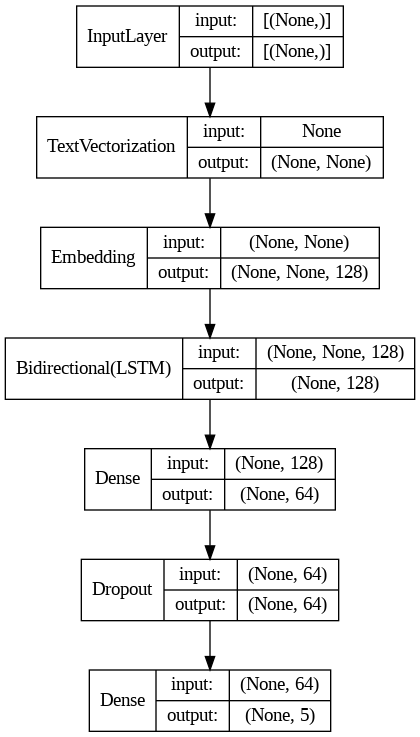

In [15]:
# Visualizing the architecture of the model
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=False)

### **Compile and Train the Model**

In [16]:
model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
              loss="sparse_categorical_crossentropy",
              metrics="accuracy")

In [17]:
tf.random.set_seed(123)
history = model.fit(train_dataset, epochs=epochs, validation_data=test_dataset)

Epoch 1/10
56/56 [==============================] - 27s 261ms/step - loss: 1.4721 - accuracy: 0.3354 - val_loss: 1.1519 - val_accuracy: 0.5438
Epoch 2/10
56/56 [==============================] - 11s 193ms/step - loss: 0.8153 - accuracy: 0.6927 - val_loss: 0.5048 - val_accuracy: 0.8539
Epoch 3/10
56/56 [==============================] - 10s 182ms/step - loss: 0.2143 - accuracy: 0.9472 - val_loss: 0.2157 - val_accuracy: 0.9258
Epoch 4/10
56/56 [==============================] - 8s 140ms/step - loss: 0.0482 - accuracy: 0.9916 - val_loss: 0.1636 - val_accuracy: 0.9483
Epoch 5/10
56/56 [==============================] - 8s 146ms/step - loss: 0.0087 - accuracy: 1.0000 - val_loss: 0.1377 - val_accuracy: 0.9596
Epoch 6/10
56/56 [==============================] - 9s 158ms/step - loss: 0.0101 - accuracy: 0.9983 - val_loss: 0.1886 - val_accuracy: 0.9236
Epoch 7/10
56/56 [==============================] - 8s 146ms/step - loss: 0.0068 - accuracy: 0.9994 - val_loss: 0.1217 - val_accuracy: 0.9663
Epo

**Save model**

In [10]:
drive.mount("/content/drive/")

Mounted at /content/drive/


In [22]:
model.save("/content/drive/MyDrive/models/SentimentAnalysis_LSTM_BBC.keras")

### **Dataset Evaluation**

In [19]:
print(model.evaluate(train_dataset, verbose=0))
print(model.evaluate(test_dataset, verbose=0))

[0.00013535353355109692, 1.0]
[0.106631800532341, 0.9707865118980408]


The training set achieves an accuracy of 100% in just 10 epochs!, while the test set accuracy is 97%. This indicates that the model is highly effective but shows evidence of slight overfitting, despite incorporating a dropout layer. As the number of epochs increases, the training set accuracy remains at 100%, but that of the test set begins to decrease. To achieve even more optimal results and counteract this slight overfitting, it would be advisable to expand the training dataset or employ more robust architectures, such as transformer networks.

In [23]:
# Function to plot the metrics
def plot_metrics(history=history, metric="loss", renderer=None, epochs=epochs):
  losses = history.history[metric]
  val_losses = history.history[f"val_{metric}"]
  list_epochs = np.arange(1, epochs+1)
  metric = metric.capitalize()

  fig=go.Figure()
  fig.add_trace(go.Scatter(x=list_epochs, y=losses, name=metric, line=dict(color="blue", width=2)))
  fig.add_trace(go.Scatter(x=list_epochs, y=val_losses, name=f"Val {metric}", line=dict(color="#FF6600", width=2)))
  fig.update_xaxes(title_text="Epoch")
  fig.update_yaxes(title_text=metric)
  fig.update_layout(title=f"Evolution of {metric} across Epochs",
                    title_font=dict(size=20),
                    title_x=0.5,
                    height=500,
                    width=1200)

  fig.show(renderer)

**Interactive graphics**

In [21]:
plot_metrics()

In [24]:
plot_metrics(metric="accuracy")

**Images for GitHub**

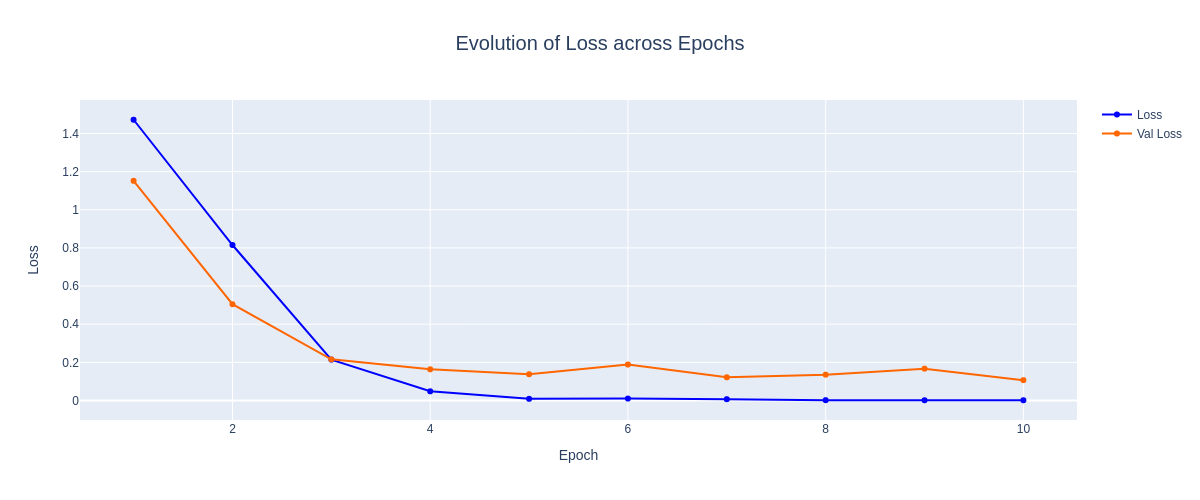

In [25]:
plot_metrics(renderer="png")

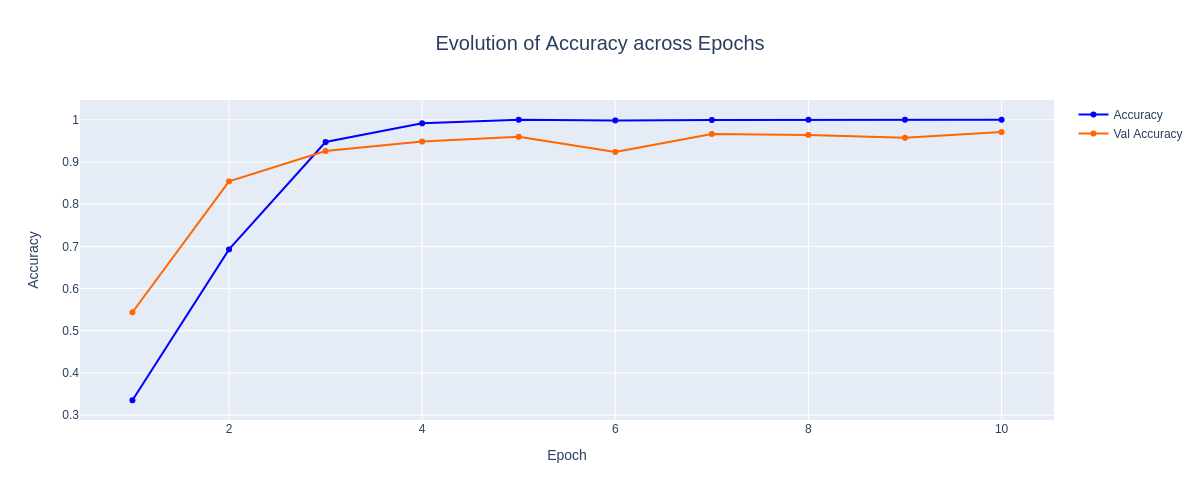

In [26]:
plot_metrics(renderer="png", metric="accuracy")

**Confusion Matrix**

In [49]:
texts_test, labels_test = [], []
for text, label in test_dataset.unbatch():
  texts_test.append(text.numpy())
  labels_test.append(label.numpy())

texts_test =  np.array(texts_test)
labels_test = np.array(labels_test)

labels_test_pred = model.predict(texts_test, batch_size=batch_size, verbose=0)
labels_test_pred = np.argmax(labels_test_pred, axis=-1)

In [52]:
# Consolidating the accuracy of the testing set
np.mean(labels_test == labels_test_pred)

0.9707865168539326

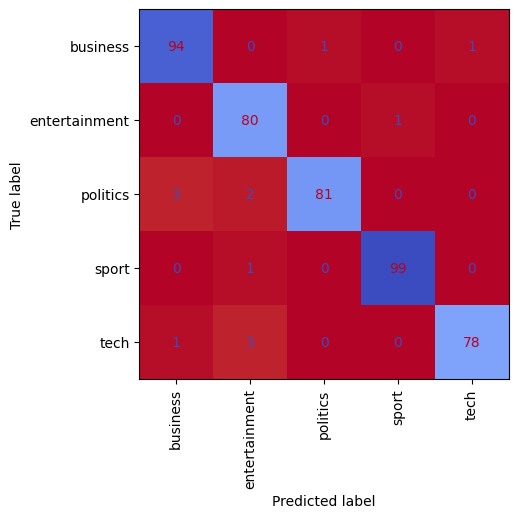

In [58]:
cm = confusion_matrix(labels_test, labels_test_pred)
cmd = ConfusionMatrixDisplay(cm, display_labels=class_names)
cmd.plot(colorbar=False, cmap="coolwarm_r", xticks_rotation="vertical");

In [64]:
((np.bincount(labels_test) - np.diag(cm)) / np.bincount(labels_test)) * 100

array([2.08333333, 1.2345679 , 5.81395349, 1.        , 4.87804878])

The model demonstrates excellent performance in classifying BBC news articles in the test set, accurately categorizing nearly 100% of the articles across the 5 categories. However, it encounters slightly more difficulty in correctly classifying articles in 'politics' (with a 5.8% error rate) and 'tech' (with a 4.9% error rate).

### **Predictions with the trained model**

In [4]:
# Custom standardization function
@tf.keras.saving.register_keras_serializable()
def preprocessing(text):
  text = tf.strings.lower(text)
  text = tf.strings.regex_replace(text, r'[!"#$£%&()\*\+,-\./:;<=>?@\[\\\]^_`{|}~\']', "")
  text = tf.strings.regex_replace(text, r"\n+", " ")
  return text

In [5]:
# Load model
tf.keras.backend.clear_session()
model = tf.keras.models.load_model("/content/drive/MyDrive/models/SentimentAnalysis_LSTM_BBC.keras")
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVe  (None, None)              0         
 ctorization)                                                    
                                                                 
 embedding (Embedding)       (None, None, 128)         1280000   
                                                                 
 bidirectional (Bidirection  (None, 128)               98816     
 al)                                                             
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 5)                 3

In [33]:
def predict_label(texts, labels, random=True):
  label_names = class_names
  label_colors = ["#1f77b4", "#ff7f0e", "#9467bd", "#2ca02c", "#17becf"]
  indice = np.random.choice(len(texts)) if random else 0
  labels_pred = model.predict(texts, verbose=0)
  labels_pred = np.argmax(labels_pred, axis=-1)

  html_content = f"""
    <b>News Article:</b><br><br>
    {texts[indice].numpy().decode("utf-8")}<br><br>
    <b>True Label: <span style="color: {label_colors[labels[indice]]}">{label_names[labels[indice]].capitalize()}</span></b><br><br>
    <b>Predicted Label: <span style="color: {label_colors[labels_pred[indice]]}">{label_names[labels_pred[indice]].capitalize()}</span></b>
    """
  display(HTML(html_content))

**Test Dataset**

In [23]:
texts, labels = next(iter(test_dataset))

In [64]:
print(class_names)
print(np.unique(labels))

['business', 'entertainment', 'politics', 'sport', 'tech']
[0 1 2 3 4]


In [34]:
predict_label(texts, labels, random=False)

In [ ]:
predict_label(texts, labels)

In [37]:
predict_label(texts, labels)

In [35]:
predict_label(texts, labels)

In [53]:
predict_label(texts, labels)

**Other News Articles**

In [59]:
text = """
Tesla's Market Value Surges to Record $700 Billion, Cementing Musk's Payout\n\nTesla Inc's market value soared to over $700 billion for the first time,
making it the fifth-most valuable company in the S&P 500 and surpassing Facebook Inc.
The surge comes after the electric carmaker reported record vehicle deliveries for the fourth quarter.
"""
text = tf.constant([text], tf.string)
label = tf.constant([0], tf.int32)

predict_label(text, label)

In [60]:
text = """
Apple Unveils New MacBook Pro with M1 Pro and M1 Max Chips\n\nApple Inc. has announced its latest MacBook Pro models powered by
the M1 Pro and M1 Max chips, promising significant performance improvements in graphics and processing power.
The new laptops feature a revamped design, longer battery life, and enhanced display technology.
"""

text = tf.constant([text], tf.string)
label = tf.constant([4], tf.int32)

predict_label(text, label)

In [63]:
text = """
Netflix Releases Trailer for Highly Anticipated Fantasy Series 'The Witcher: Blood Origin'\n\n\n
Netflix has dropped the trailer for 'The Witcher: Blood Origin,' a prequel to the popular fantasy series 'The Witcher.'
Set in an elven world 1,200 years before the events of the original series, the show follows the creation of the
first Witcher and the pivotal events that shaped the world of the Continent. Fans are eagerly awaiting its release.
"""

text = tf.constant([text], tf.string)
label = tf.constant([1], tf.int32)

predict_label(text, label)

You can observe that the model correctly classified the news articles from the test set, as well as others that are not found in either the training or test set, demonstrating its effectiveness in the task of multiclass text classification.

### **Visualize Word Embeddings with Principal Component Analysis (PCA)**

In [6]:
# Obtaining the vocabulary from the encoder layer and the weights from the trained embedding layer

vocab = model.layers[0].get_vocabulary()
vocab = {word:i for i, word in enumerate(vocab)}

embedding = model.get_layer("embedding").get_weights()[0]
embedding.shape #(vocab_size, embedding_dim)

(10000, 128)

In [7]:
def compute_pca(X, n_components=2):
  pca = PCA(n_components=n_components, random_state=42)
  X_pca = pca.fit_transform(X)
  return X_pca

In [8]:
embedding_2d = compute_pca(embedding)
embedding_3d = compute_pca(embedding, n_components=3)

embedding_2d.shape, embedding_3d.shape

((10000, 2), (10000, 3))

In [10]:
# Some exemplary words
words = ["company", "market", "investment", "economy", "finance",
         "film", "music", "actor", "show", "celebrity",
         "government", "election", "policy", "politician", "democracy",
         "game", "team", "football", "match", "championship",
         "technology", "digital", "innovation", "internet", "software"]

colors = ["#1f77b4", "#ff7f0e", "#9467bd", "#2ca02c", "#17becf"]
list_colors = np.array([[c]*5 for c in colors]).flatten()

In [11]:
words_2d = np.array([embedding_2d[vocab.get(word, 1)] for word in words]) #Index 1 corresponds to [UNK]
words_3d = np.array([embedding_3d[vocab.get(word, 1)] for word in words])

**With Plotly (interactive graph)**

In [24]:
fig = go.Figure()

for i, name in enumerate(class_names):
  fig.add_trace(go.Scatter(x=words_2d[i*5:(i+1)*5, 0], y=words_2d[i*5:(i+1)*5, 1],
                           mode="markers+text", marker_color=colors[i],
                           text=words[i*5:(i+1)*5], textposition="top right",
                           marker_size=10, textfont_size=13,
                           name=name))

fig.update_layout(title="<b>2D Embeddings of BBC News Article Words</b>",
                  title_font=dict(size=18), title_x=0.5, height=800, width=1200,
                  xaxis_title="<b>$Z_1$</b>", yaxis_title="<b>$Z_2$</b>")

fig.show()

In [25]:
fig = go.Figure()

for i, name in enumerate(class_names):
  fig.add_trace(go.Scatter3d(x=words_3d[i*5:(i+1)*5, 0], y=words_3d[i*5:(i+1)*5, 1], z=words_3d[i*5:(i+1)*5, 2],
                             mode="markers+text", marker_color=colors[i],
                             text=words[i*5:(i+1)*5], textposition="top right",
                             marker_size=7, textfont_size=13,
                             name=name))

fig.update_layout(title="<b>3D Embeddings of BBC News Article Words</b>",
                  title_font=dict(size=18), title_x=0.5, height=800, width=1200,
                  scene=dict(xaxis_title="<b>Z_1</b>", yaxis_title="<b>Z_2</b>", zaxis_title="<b>Z_3</b>"))

fig.show()

In [26]:
# Function to create gifs

def create_gif(gif_file, fig, fps=1):

  images = []
  angles = np.arange(0, 361, 20)

  # Initial Image
  fig.write_image("temp.png")
  images.append(imageio.imread("temp.png"))
  os.remove("temp.png")

  for angle in angles:
    fig.update_layout(scene_camera=dict(
        eye=dict(x=np.sin(np.radians(angle)), y=np.cos(np.radians(angle)))
        )
    )
    fig.write_image("temp.png")
    images.append(imageio.imread("temp.png"))
    os.remove("temp.png")

  with imageio.get_writer(gif_file, mode="I", loop=0, fps=fps) as writer:
    for image in images:
      writer.append_data(image)

In [15]:
!pip install tensorflow_docs -q

import tensorflow_docs.vis.embed as embed


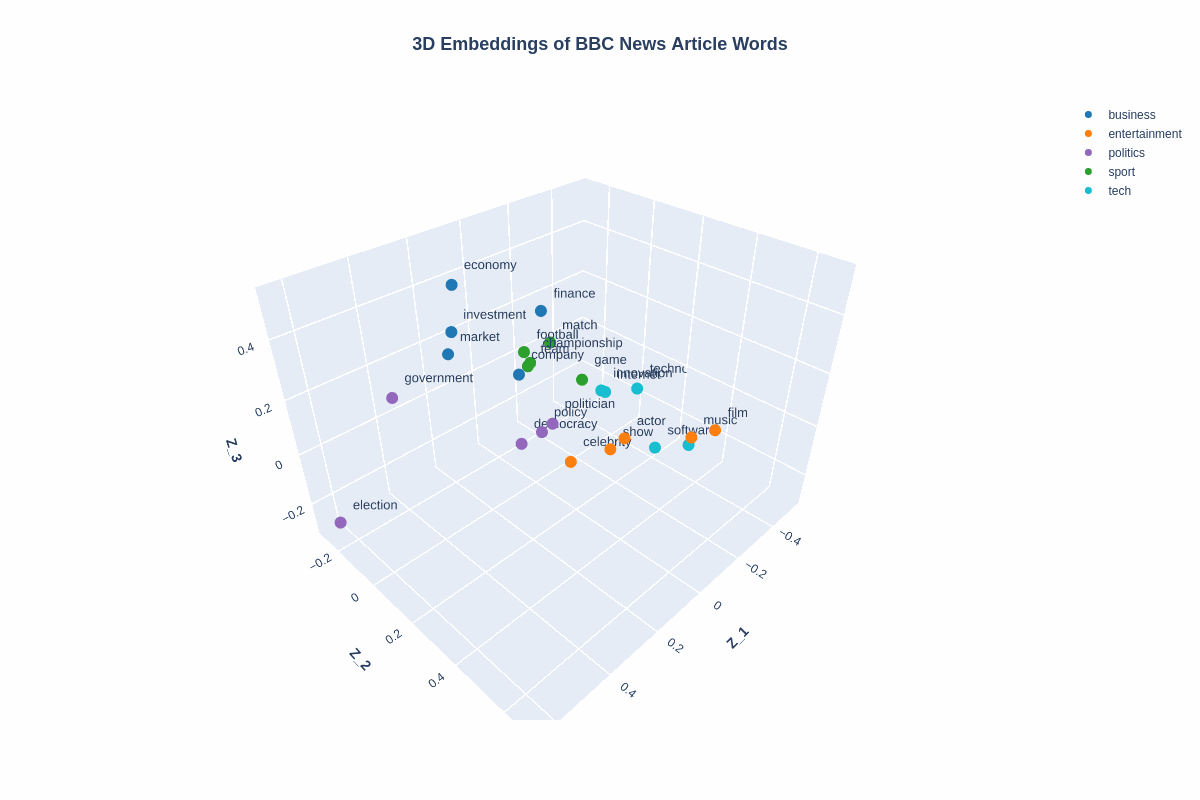

In [27]:
# Generate a GIF of the 3D word embeddings
directory_images = "/content/drive/MyDrive/images/text_classification"
directory_tc = os.path.join(directory_images, "lstm_bbc")
os.makedirs(directory_tc, exist_ok=True)
gif_file = os.path.join(directory_tc, "embedding_3d.gif")

create_gif(gif_file, fig, fps=0.5)
embed.embed_file(gif_file)

**With Matplotlib (for GitHub)**

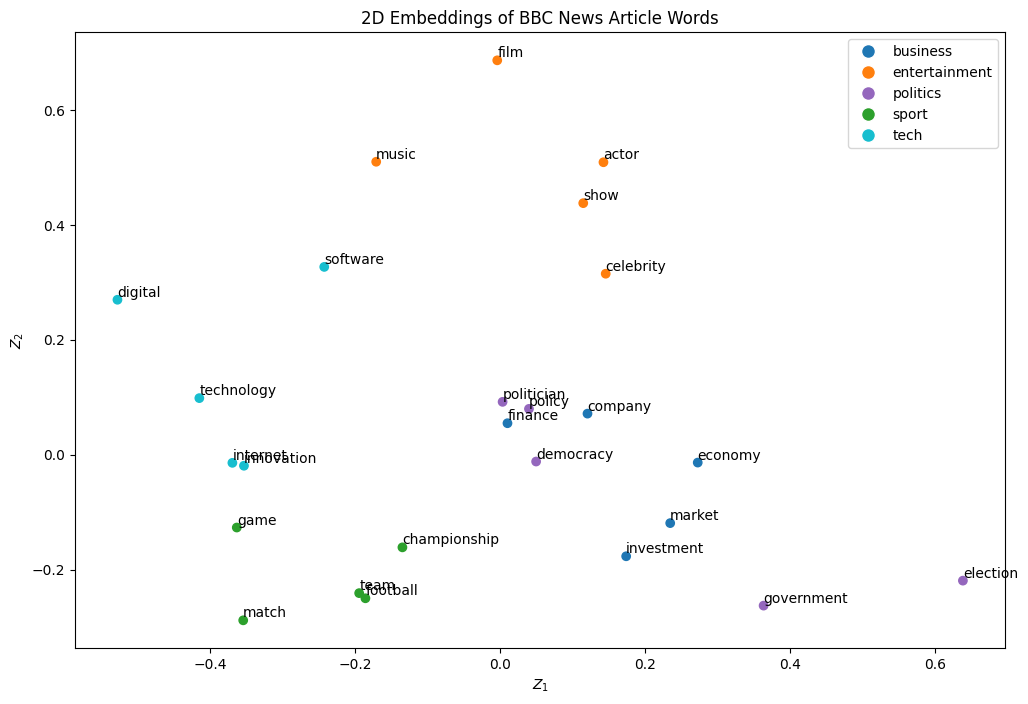

In [78]:
plt.figure(figsize=(12, 8))
plt.scatter(words_2d[:, 0], words_2d[:, 1], c=list_colors)
for i, word in enumerate(words):
    plt.annotate(word, xy=(words_2d[i, 0], words_2d[i, 1]), ha="left", va="bottom")

legend_handles = [plt.Line2D([0], [0], marker="o", color="w", markerfacecolor=color, markersize=10, label=label) for color, label in zip(colors, class_names)]
plt.legend(handles=legend_handles, loc="best")

plt.xlabel("$Z_1$")
plt.ylabel("$Z_2$")
plt.title("2D Embeddings of BBC News Article Words")
plt.show()

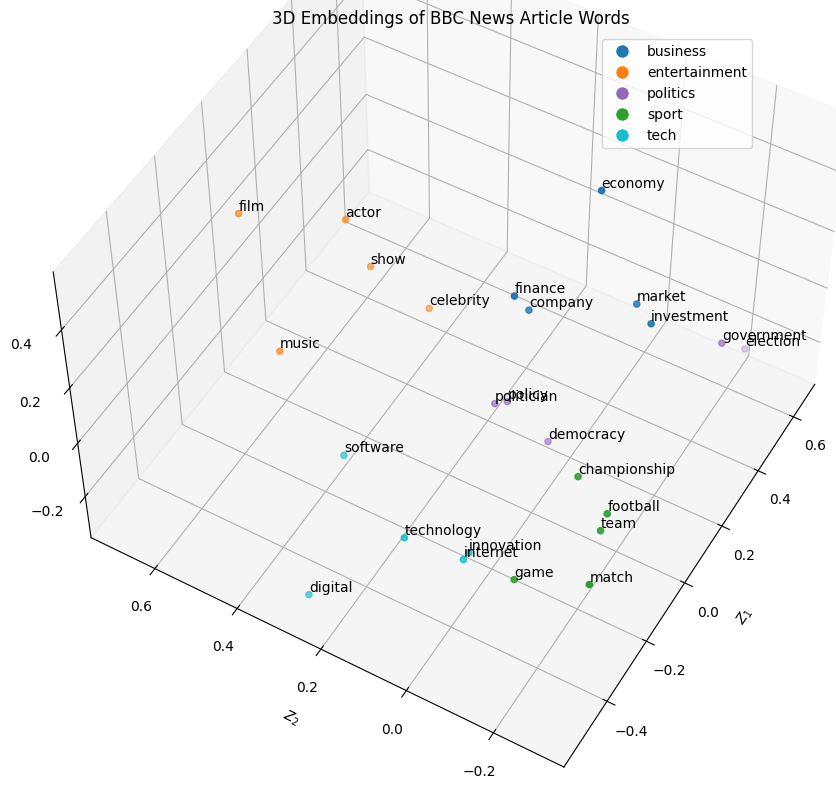

In [77]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(words_3d[:, 0], words_3d[:, 1], words_3d[:, 2], c=list_colors)

for i, word in enumerate(words):
    ax.text(words_3d[i, 0], words_3d[i, 1], words_3d[i, 2], word, ha="left", va="bottom")

legend_handles = [plt.Line2D([0], [0], marker="o", color="w", markerfacecolor=color, markersize=10, label=label) for color, label in zip(colors, class_names)]
plt.legend(handles=legend_handles, loc="best")

ax.view_init(elev=50, azim=210)
ax.set_box_aspect(None, zoom=1.4)

ax.set_xlabel("$Z_1$")
ax.set_ylabel("$Z_2$")
ax.set_zlabel("$Z_3$")
plt.title("3D Embeddings of BBC News Article Words")
plt.show()

Thanks to the use of **PCA**, we can now visualize the trained weights of the embedding layer in 2D and 3D, which facilitates a better understanding of the word distribution. By reducing the dimensions of the vector representation of each vocabulary word, originally 128 dimensions, we can observe how they are grouped in a lower-dimensional space. This technique provides a clearer insight into how the model has captured the semantic relationships between words. The coherent grouping of common words in the five categories suggests successful model training. Moreover, the clear separation between word groups, except in the 'business' and 'politics' categories, where a close relationship is observed, reflects the strong discriminative capacity of the model. It's important to highlight that the observed overlap between 'business' and 'politics' is not occasional, but a reflection of the reality in which politics and business are intrinsically intertwined and frequently influence each other. This constant interaction in the real world is captured by the model, demonstrating its ability to learn and represent complex semantic relationships.